# Graph Characteristics

## Board Characteristics

- $6 \times 6$ Matrix
- Each square contains a number/color combination (eg. 1, Blue)
- Because it is a $6 \times 6$ matrix we chose numbers 1-6 and six colors, namely (blue, pink, white, green, red, & yellow)
- We use every possible permutation of the number/color combination to give us $6^2$ squares.

## Node Characteristics
- Tile Number
- Node Color
- Node Number

## Edge Characteristics
- Edge exists iff 
    - same node number
    - same node color
    - both nodes exist on same x or y axis

### Let's get some basic imports out of the way

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy as sp
import itertools
import copy 

## Next, We structure our squares, tiles, and boards so we can visualize the boards.
#### Implementing classes with all necessary methods

In [6]:
class Square:
    def __init__(self, color, number):
        self.color = color
        self.number = number
        
class Tile:
    def __init__(self, tile_number, matrix):
        self.number = tile_number
        # TODO: check if perfect square?
        self.matrix = matrix
        self.orientation = 0
    
    # since we always have a matrix and to make future operations simpler, we adjust 
    # to return the integer which, when squared, forms the size of our matrix
    def get_shape(self):
        return self.matrix.shape[0]
    
    def orient_tile(self, desired_orientation):
        change = desired_orientation - self.orientation
        if (change == 0):
            return
        # in OUR SPECIFIC CASE this only occurs from 270 to zero
        if (change < 0):
            self.rotate_right()
        elif (change == 90):
            self.rotate_right()
        elif (change == 180):
            self.rotate_right()
            self.rotate_right()
        elif (change == 270):
            self.rotate_right()
            self.rotate_right()
            self.rotate_right()
          
        self.orientation = desired_orientation
    
    def rotate_right(self):
        self.matrix = np.rot90(self.matrix, k=-1, axes=(0, 1))
        
    def print_tile(self):
        for row in self.matrix:
            for cell in row:
                print(cell.color, end=' ')
                print(cell.number, end=' ')
            print("\n")
            
    def print_tile_row(self, row):
        for cell in self.matrix[row]:
            print(cell.color, end=' ')
            print(cell.number, end=' | ')
            
    def get_tile_row(self, row):
        return self.matrix[row]

class Board:
    def __init__(self, matrix):
        # constructor will accept a matrix of Tiles.
        self.matrix = matrix
        self.graph = nx.Graph()
        self.adjacency_dict = {}
        # TODO: check if perfect square?
        
    def print_board(self):
        tile_shape = self.matrix[0][0].get_shape()
        
        for x in range(tile_shape):
            self.matrix[0][0].print_tile_row(x)
            self.matrix[0][1].print_tile_row(x)
            print("\n")
         
        for x in range(tile_shape):
            self.matrix[1][0].print_tile_row(x)
            self.matrix[1][1].print_tile_row(x)
            print("\n")
        
    # deconstructs the board into a matrix of squares
    def deconstruct_board(self):
        tile_shape = self.matrix[0][0].get_shape()
        deconstructed_matrix = []
        for x in range(tile_shape):
            row = np.concatenate([self.matrix[0][0].get_tile_row(x), self.matrix[0][1].get_tile_row(x)])
            deconstructed_matrix.append(row)
            
        for x in range(tile_shape):
            row = np.concatenate([self.matrix[1][0].get_tile_row(x), self.matrix[1][1].get_tile_row(x)])
            deconstructed_matrix.append(row)
            
        return deconstructed_matrix
    
    def build_graph(self):
        deconstructed_matrix = np.array(self.deconstruct_board()).reshape(6,6)
        # make each square a graph node
        for row in deconstructed_matrix:
            for elem in row:
                label = elem.color + str(elem.number)
                self.graph.add_node(elem, label=label)

        # for each node draw edges
        for row_index, row in enumerate(deconstructed_matrix, start=0):
                for col_index, elem in enumerate(row, start=0):
                    # examine column, if same number or color, create an edge between the two nodes 
                    # library handles case of duplicate edges
                    for square in deconstructed_matrix[:,col_index]:
                        if(square.color == elem.color or square.number == elem.number):
                            self.graph.add_edge(square,elem)

                    # examine row, if same number or color, create an edge between the two nodes 
                    # library handles case of duplicate edges
                    for square in deconstructed_matrix[row_index]:
                        if(square.color == elem.color or square.number == elem.number):
                            self.graph.add_edge(square,elem)
                            
        self.graph.remove_edges_from(nx.selfloop_edges(self.graph))
        
    def print_graph(self):
        labels = nx.get_node_attributes(self.graph, 'label')
        pos = nx.spring_layout(self.graph,k=0.75,iterations=20)
        plt.figure(3,figsize=(10,6))
        nx.draw(self.graph, pos, labels=labels, node_size=500, font_weight='bold', node_color='y')
        plt.show()
        
    def get_laplacian_matrix(self):
        return nx.laplacian_matrix(self.graph)
        
    def get_adjacency_matrix(self):
        return nx.adjacency_matrix(self.graph)

    def is_connected(self):
        return nx.is_connected(self.graph)
    
    def print_graph_characteristics(self):
        print("Graph characteristics: ")
        print(self.graph.number_of_nodes(), "nodes")
        print(self.graph.number_of_edges(), "edges")
        print("Connected?", nx.is_connected(self.graph))
        
    def set_adjacency_dict(self):
        if self.graph.number_of_nodes() == 0:
            return "ERROR"
        
        adjacency_dict = {}

        for n, nbrdict in self.graph.adjacency():
            adjacency_dict[n.color + str(n.number)] = []
            for item in nbrdict:
                adjacency_dict[n.color + str(n.number)].append(item.color + str(item.number))

        self.adjacency_dict = adjacency_dict
    
    def print_adjacency_dict(self):
        if self.graph.number_of_nodes() == 0:
            return "ERROR"
        
        adjacency_dict = {}

        for n, nbrdict in self.graph.adjacency():
            adjacency_dict[n.color + str(n.number)] = []
            for item in nbrdict:
                adjacency_dict[n.color + str(n.number)].append(item.color + str(item.number))

        #print adjancecy dict for verfication of correctness
        for k, v in adjacency_dict.items():
            print (k, '-->', v)

### We have the key classes implemented. Let's build the actual microrobots board.

In [7]:
def build_actual_blackside_microrobots_board():
    tileOne = Tile(1, np.array([[Square("W", 6), Square("B", 6), Square("B", 2)],
             [Square("R", 3), Square("Y", 4),Square("W", 3)],
             [Square("B", 3), Square("G", 4), Square("W", 5)]], dtype=np.object).reshape(3,3))

    tileTwo = Tile(2, np.array([[Square("P", 5), Square("P", 2), Square("P", 3)],
                 [Square("R", 6), Square("R", 4),Square("Y", 3)],
                 [Square("B", 4), Square("G", 5), Square("G", 3)]], dtype=np.object).reshape(3,3))

    tileThree = Tile(3, np.array([[Square("B", 1), Square("R", 2), Square("W", 4)],
                 [Square("W", 1), Square("G", 2),Square("G", 6)],
                 [Square("Y", 2), Square("W", 2), Square("P", 4)]], dtype=np.object).reshape(3,3))

    tileFour = Tile(4, np.array([[Square("P", 1), Square("Y", 6), Square("Y", 1)],
                 [Square("Y", 5), Square("B", 5),Square("R", 5)],
                 [Square("P", 6), Square("R", 1), Square("G", 1)]], dtype=np.object).reshape(3,3))

    return Board(np.array([[tileOne, tileTwo], [tileThree, tileFour]], dtype=np.object).reshape(2,2))

blackside_board = build_actual_blackside_microrobots_board()

blackside_board.print_board()

def build_actual_copperside_microrobots_board():
    tileOne = Tile(1, np.array([[Square("P", 2), Square("G", 3), Square("P", 4)],
             [Square("W", 4), Square("W", 5),Square("W", 1)],
             [Square("P", 1), Square("G", 5), Square("G", 4)]], dtype=np.object).reshape(3,3))

    tileTwo = Tile(2, np.array([[Square("W", 3), Square("G", 2), Square("R", 5)],
                 [Square("G", 1), Square("W", 2),Square("G", 6)],
                 [Square("Y", 3), Square("Y", 1), Square("R", 1)]], dtype=np.object).reshape(3,3))

    tileThree = Tile(3, np.array([[Square("B", 2), Square("Y", 6), Square("P", 5)],
                 [Square("B", 4), Square("W", 6),Square("P", 6)],
                 [Square("B", 3), Square("Y", 4), Square("B", 1)]], dtype=np.object).reshape(3,3))

    tileFour = Tile(4, np.array([[Square("P", 3), Square("R", 6), Square("R", 2)],
                 [Square("B", 6), Square("Y", 2),Square("R", 3)],
                 [Square("B", 5), Square("Y", 5), Square("R", 4)]], dtype=np.object).reshape(3,3))

    return Board(np.array([[tileOne, tileTwo], [tileThree, tileFour]], dtype=np.object).reshape(2,2))

copperside_board = build_actual_copperside_microrobots_board()
print("")
copperside_board.print_board()



W 6 | B 6 | B 2 | P 5 | P 2 | P 3 | 

R 3 | Y 4 | W 3 | R 6 | R 4 | Y 3 | 

B 3 | G 4 | W 5 | B 4 | G 5 | G 3 | 

B 1 | R 2 | W 4 | P 1 | Y 6 | Y 1 | 

W 1 | G 2 | G 6 | Y 5 | B 5 | R 5 | 

Y 2 | W 2 | P 4 | P 6 | R 1 | G 1 | 


P 2 | G 3 | P 4 | W 3 | G 2 | R 5 | 

W 4 | W 5 | W 1 | G 1 | W 2 | G 6 | 

P 1 | G 5 | G 4 | Y 3 | Y 1 | R 1 | 

B 2 | Y 6 | P 5 | P 3 | R 6 | R 2 | 

B 4 | W 6 | P 6 | B 6 | Y 2 | R 3 | 

B 3 | Y 4 | B 1 | B 5 | Y 5 | R 4 | 



## Now, we implement the ability to generate random boards

In [8]:
# takes n numbers and n colors and generates a random n x n microrobots board
def generate_random_board(numbers, colors):
        # TODO check if lists are equal in size, error if not
        # TODO generalize to n x n by defining tile size rather than just using 3x3
        
        # build hashmap to store numbers and colors
        expected_matrix_size = len(numbers) * len(colors)
        hashmap = {}
        for color in colors:
            hashmap[color] = []
            for num in numbers:
                hashmap[color].append(num)
        
        hashmap_copy = hashmap.copy()
        
        # generates a random unique (exactly once) set of combinations of 
        # numbers and colors and returns them as an instance of Square
        squares = []
        colors_copy = colors.copy()
        while len(colors_copy) > 0:
            # chose random color
            rand_color = random.choice(colors_copy)
            rand_num = random.choice(hashmap_copy[rand_color])
            hashmap_copy[rand_color].pop(hashmap_copy[rand_color].index(rand_num))
            squares.append(Square(rand_color, rand_num))
            
            # now we check if we used last num, if so remove color
            # care, this is terminating condition on while loop
            if len(hashmap_copy[rand_color]) == 0:
                colors_copy.pop(colors_copy.index(rand_color))

                
        # doouble check if len is as expected
        if len(squares) != expected_matrix_size:
            print("ERROR: You only produced ", len(squares), "squares and we expected", expected_matrix_size)
            return
        
        # generate 4 arrays of 9 
        # The generation of these tiles is obviously not, itself, random. I dont this matters because what we are really generating is 
        # a random matrix and by randomness of actual color/number combos, fixing the placement of the tiles should not impact outcome
        split_squares = np.array_split(squares, 4)
        board = Board(np.array([[Tile(1, split_squares[0].reshape(3,3)), Tile(2,split_squares[1].reshape(3,3))],
                 [Tile(3,split_squares[2].reshape(3,3)), Tile(4, split_squares[3].reshape(3,3))]], dtype=np.object).reshape(2,2))
        
        return board            
            
random_board = generate_random_board([1,2,3,4,5,6], ["W", "R", "B", "P", "Y", "G"])
random_board.print_board()


R 6 | R 2 | B 1 | Y 4 | B 6 | R 4 | 

Y 3 | P 2 | G 4 | R 5 | Y 1 | G 3 | 

W 2 | W 5 | G 2 | G 6 | R 3 | B 5 | 

Y 2 | R 1 | Y 6 | W 1 | G 1 | B 2 | 

W 6 | Y 5 | W 3 | G 5 | B 4 | P 5 | 

W 4 | P 6 | B 3 | P 4 | P 3 | P 1 | 



### Now, let's explore the connectedness of a board.
##### We consider two squares connected iff
    - They exist on the same row OR column AND
    - They are the the same color OR number
    
#### Here, we draw the resulting graph of the ACTUAL blackside microrobots board and label it with the associated node values

Graph characteristics: 
36 nodes
58 edges
Connected? True


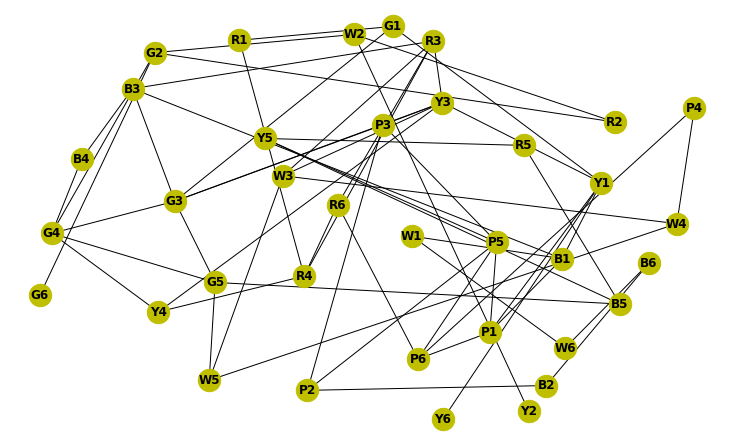

In [9]:

blackside_board.build_graph()
blackside_board.print_graph_characteristics()
blackside_board.print_graph()
    

### Just to make sure we got everything right let's take a look at the adjacency list.

In [10]:
blackside_board.set_adjacency_dict()
blackside_board.print_adjacency_dict()


W6 --> ['W1', 'B6']
B6 --> ['W6', 'B2']
B2 --> ['B6', 'P2']
P5 --> ['P1', 'Y5', 'P6', 'P2', 'P3']
P2 --> ['B2', 'P5', 'P3']
P3 --> ['P5', 'P2', 'Y3', 'G3']
R3 --> ['B3', 'W3', 'R6', 'R4', 'Y3']
Y4 --> ['G4', 'R4', 'Y3']
W3 --> ['R3', 'W5', 'W4', 'Y3']
R6 --> ['R3', 'P6', 'R4']
R4 --> ['R3', 'Y4', 'R6', 'R1']
Y3 --> ['P3', 'R3', 'Y4', 'W3', 'G3', 'Y1']
B3 --> ['R3', 'B1', 'B4', 'G3']
G4 --> ['Y4', 'G2', 'B4', 'G5', 'G3']
W5 --> ['W3', 'W4', 'G5']
B4 --> ['B3', 'G4']
G5 --> ['G4', 'W5', 'B5', 'G3']
G3 --> ['P3', 'Y3', 'B3', 'G4', 'G5', 'G1']
B1 --> ['B3', 'W1', 'P1', 'Y1']
R2 --> ['G2', 'W2']
W4 --> ['W3', 'W5', 'P4']
P1 --> ['P5', 'B1', 'P6', 'Y1']
Y6 --> ['Y1']
Y1 --> ['Y3', 'B1', 'P1', 'Y6', 'G1']
W1 --> ['W6', 'B1']
G2 --> ['G4', 'R2', 'W2', 'G6']
G6 --> ['G2']
Y5 --> ['P5', 'B5', 'R5']
B5 --> ['G5', 'Y5', 'R5']
R5 --> ['Y5', 'B5']
Y2 --> ['W2']
W2 --> ['R2', 'G2', 'Y2']
P4 --> ['W4', 'P6']
P6 --> ['P5', 'R6', 'P1', 'P4']
R1 --> ['R4', 'G1']
G1 --> ['G3', 'Y1', 'R1']



#### Alright, we compared that to the actual board and nothing looks sus!

# TESTING RANDOMLY GENERATED THEORY

 - We questioned whether, just by nature, these boards tend to be connected even when randomly generated. The answer to that question is no.
 
### Question:

#### As n grows, either n of randomly generated graphs or actual n x n number of nodes, does the probability of connectedness approach 0 or 1?

##### KOLMOGOROV’S ZERO-ONE LAW WITH APPLICATIONS
 - http://math.uchicago.edu/~may/REU2017/REUPapers/McNamara.pdf

In [11]:
%%time

# generates n random boards with the given numbers & colors arrays
def generate_random_boards(n, numbers, colors):
    boards_list = []
    for x in range(n):
        b = generate_random_board(numbers, colors)
        b.build_graph()
        boards_list.append(b)
    return boards_list

nums = [1,2,3,4,5,6]
cols = ["W", "R", "B", "P", "Y", "G"]
boards_list = generate_random_boards(10, nums, cols)

count_not_connected = 0

for b in boards_list:
    print("\n")
    print(" ---------------------------------- ")
    print("\n")
    b.print_board()
    b.print_graph_characteristics()
    
    if not nx.is_connected(b.graph):
#         b.print_graph()
#         b.set_adjacency_dict()
#         b.print_adjacency_dict()
        count_not_connected = count_not_connected + 1

print("    ==============================================     ")

print(count_not_connected, " out of ", len(boards_list)," graphs were not connected")




 ---------------------------------- 


W 3 | R 5 | P 1 | P 6 | R 3 | Y 6 | 

Y 1 | R 4 | B 6 | P 4 | P 2 | G 4 | 

R 6 | B 5 | P 3 | G 1 | Y 3 | G 3 | 

Y 2 | Y 4 | R 1 | G 6 | G 5 | R 2 | 

Y 5 | B 4 | G 2 | W 1 | B 2 | W 5 | 

W 6 | P 5 | B 3 | B 1 | W 2 | W 4 | 

Graph characteristics: 
36 nodes
54 edges
Connected? True


 ---------------------------------- 


P 1 | G 3 | G 2 | B 4 | Y 5 | Y 2 | 

B 3 | P 6 | R 3 | R 5 | P 3 | B 6 | 

W 1 | B 2 | B 1 | W 4 | P 4 | W 6 | 

W 3 | W 5 | W 2 | G 6 | R 1 | R 2 | 

P 5 | Y 1 | P 2 | G 5 | R 4 | G 1 | 

B 5 | R 6 | G 4 | Y 4 | Y 6 | Y 3 | 

Graph characteristics: 
36 nodes
53 edges
Connected? True


 ---------------------------------- 


W 1 | W 6 | W 3 | P 5 | B 4 | B 2 | 

R 5 | P 1 | W 4 | W 5 | G 1 | Y 5 | 

B 6 | P 4 | G 3 | W 2 | P 2 | Y 6 | 

Y 1 | B 1 | R 2 | G 6 | P 3 | R 1 | 

G 2 | B 3 | G 4 | Y 4 | R 3 | R 6 | 

Y 2 | P 6 | B 5 | R 4 | G 5 | Y 3 | 

Graph characteristics: 
36 nodes
46 edges
Connected? False


 ---------------

# ANSWERING IF THE ACTUAL GAMEBOARD IS ALWAYS CONNECTED

#### Next, we examine all of the different permutations of the actual board graph and verify they are all connected

#### Expected outcome

There are $4!$ ways to place the tiles in the $4$ slots. There are $4^4$ independent rotations of the individual tiles.

Consider the tile placement without rotation. For each placement, without allowing rotation, there are 3 other equivalent boards. **(add explanation here)**

Consider the tile rotations, each tile has exactly 4 ways of rotating it in place with exactly one other duplicate board created. **(add explanation here)** Therefore, each board is represented by 4 x 4 equivalent arrangements determind by the slot placement and the rotational position of the first tile.

As such, we expect that there are a total of $\frac{4! \times 4^4}{4^2} = 384$ unique boards for four $3 \times 3$ tiles.

So expect to see $6144$ total boards generated by our program and $5760$ of them should be non-unique.

In [12]:
# implement a function which rotates the boards and places them in the associated "slot" until all permutations have been achieved.

def generate_all_permutations(board):
    b = board
    # generate all possible placements with tile one
    tileOne = b.matrix[0][0]
    tileTwo = b.matrix[0][1]
    tileThree = b.matrix[1][0]
    tileFour = b.matrix[1][1]
    tiles = [tileOne, tileTwo, tileThree, tileFour]
    all_placements = list(itertools.permutations(tiles))
    # generate all the rotations per tile placement
    rotations = [0, 90, 180, 270]    
    all_rotations = list(itertools.product(rotations, repeat=4))
    
    
    all_board_permutations = []
    for placement in all_placements:   
        new_board = Board(np.array(placement, dtype=np.object).reshape(2,2))
        all_board_permutations.append(new_board)
         
        for rotation in all_rotations:
            i00, i01, i10, i11 = rotation
            if (i00 == 0 and i01 ==0 and i10 == 0 and i11 == 0):
                continue
            board_copy = copy.deepcopy(new_board) 
            board_copy.matrix[0][0].orient_tile(i00)
            board_copy.matrix[0][1].orient_tile(i01)
            board_copy.matrix[1][0].orient_tile(i10)
            board_copy.matrix[1][1].orient_tile(i11)
            all_board_permutations.append(board_copy)

    # total possible boards will be = permutations_no_rotation * all_rotations
#     print("# of tile placement", len(all_placements))
#     print("# of rotations per tile placement", len(all_rotations))
#     print("# of boards with placements & rotations", len(all_board_permutations))
    
    for board in all_board_permutations:
        board.build_graph()
    
    
    return all_board_permutations
    
all_blackside_permutations = generate_all_permutations(build_actual_blackside_microrobots_board())

In [13]:

count = 0
for i, x in enumerate(all_blackside_permutations):
    if (nx.is_isomorphic(all_blackside_permutations[0].graph, all_blackside_permutations[i].graph)):
        count = count + 1

print("non unique boards that exist for blackside board #1", count)


count = 0
for board in all_blackside_permutations:
    if (not board.is_connected()):
        count = count +1

print(count, " blackside boards are not connected")


non unique boards that exist for blackside board #1 16
0  blackside boards are not connected


In [14]:
all_copperside_permutations = generate_all_permutations(build_actual_copperside_microrobots_board())

count = 0
for i, x in enumerate(all_copperside_permutations):
    if (nx.is_isomorphic(all_copperside_permutations[0].graph, all_copperside_permutations[i].graph)):
        count = count + 1

print("non unique boards that exist for copperside board #1", count)


count = 0
for board in all_copperside_permutations:
    if (not board.is_connected()):
        count = count +1

print(count, " copperside boards are not connected")


non unique boards that exist for copperside board #1 16
0  copperside boards are not connected


### How many randmoly generated graphs are connected in every iteration?

### Generate examples

In [17]:
def check_all_permutations_connected(board):
    b_all_permutations = generate_all_permutations(board)
    for b in b_all_permutations:
        if not nx.is_connected(b.graph):
            return False
    return True

nums = [1,2,3,4,5,6]
cols = ["W", "R", "B", "P", "Y", "G"]
boards_list = generate_random_boards(100, nums, cols)
strongly_connected = []

for b in boards_list:
    if nx.is_connected(b.graph):
        if check_all_permutations_connected(b):
            print(" ==========     Connected in every permutation     ========= ")
            print("")
            b.print_board()
        else:
            print("  =======   Connected in originaly permutation but not all   ======= ")
            print("")
            b.print_board()

  =======   Connected in originaly permutation but not all   ======= 

Y 1 | Y 5 | Y 3 | G 3 | B 1 | Y 2 | 

Y 4 | G 1 | G 2 | P 3 | Y 6 | G 4 | 

G 6 | B 5 | P 2 | B 6 | R 4 | P 4 | 

B 3 | W 6 | G 5 | R 1 | P 6 | W 4 | 

W 3 | B 2 | P 1 | R 2 | R 3 | R 5 | 

W 5 | B 4 | P 5 | R 6 | W 2 | W 1 | 

  =======   Connected in originaly permutation but not all   ======= 

G 5 | Y 4 | Y 2 | W 4 | R 2 | R 6 | 

B 6 | B 5 | P 6 | R 5 | R 3 | P 3 | 

Y 5 | R 1 | G 2 | Y 3 | P 1 | W 6 | 

Y 1 | G 3 | W 2 | W 3 | Y 6 | W 5 | 

P 4 | P 2 | R 4 | B 3 | W 1 | B 1 | 

B 4 | P 5 | G 1 | G 4 | B 2 | G 6 | 

  =======   Connected in originaly permutation but not all   ======= 

W 1 | W 5 | R 6 | G 1 | W 2 | W 6 | 

R 2 | G 5 | B 1 | R 5 | W 3 | G 6 | 

G 2 | P 4 | R 1 | R 3 | B 2 | W 4 | 

R 4 | B 5 | P 6 | B 6 | Y 3 | Y 6 | 

Y 2 | B 4 | Y 1 | Y 5 | P 1 | Y 4 | 

G 4 | G 3 | B 3 | P 5 | P 2 | P 3 | 

  =======   Connected in originaly permutation but not all   ======= 

G 5 | G 6 | P 4 | R 3 | R 2 | G 

I give you tiles for microrobots for n x n microrobots. You chose what n x n microrobots looks like (4 tiles, 3x3 tiles, etc). I ask "is this board fully connected?" Is there a more computationally efficient way to check if fully connected than enumerating all possible permutations and checking connectedness? Can you prove a hardness result for this?

Is this problems Co-NP Hard? should not be NP-Hard

"Fun with Algorithms" https://sites.google.com/view/fun2020/home